In [3]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from utils import greed_assignment,LAP
from plot_utils import plot_3d
from model import Siren,AssignmentModel,Autoencoder
from data_model import TravelTimeDataset,WaveSpeedDataset,get_latent,TravelTimeDatasetFixedWavespeed
from sgld import SGLD
from ot.lp import wasserstein_1d
import matplotlib.pyplot as plt
import copy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
grid_size=32
vmin=0.5 #  wave speed is scaled with unit as 10 km/s, the time is scaled with unit as 10 s and the spatial distance is scaled with unit 100 km.
vmax=2.5
n_station=20
V=np.load('data/overthrust.npy')
V=(V-V.min())/(V.max()-V.min())
V=V*(vmax-vmin)+vmin #scale
ttdata=TravelTimeDatasetFixedWavespeed(V,n_station,grid_size) #traveling time dataset

## Generate wave speed dataset

This notebook loads the dataset and neural fields generated in notebook_unkown_wavespeed.ipynb

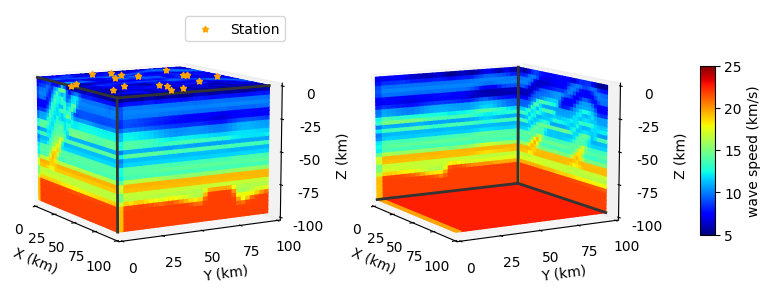

In [5]:
[fig,ax0,ax1]=plot_3d(V)
coord=ttdata.loc_station_index # coordinate index of the station
ax0.scatter3D(coord[:,0],coord[:,1],coord[:,2],s=20,depthshade=0,zorder=1e20,marker=(5, 1),color='orange',label='Station')
_=ax0.legend()

## Train neural fields model

In [6]:
batch_size_siren=1024
first_omega_0=15
hidden_omega_0=15
model_traveltime= Siren(in_features=3, out_features=n_station, hidden_features=512, 
                        hidden_layers=4, outermost_linear=True,first_omega_0=first_omega_0, hidden_omega_0=hidden_omega_0).to(device)
optimizer = torch.optim.Adam(model_traveltime.parameters(), lr=0.00001)
loss_function=torch.nn.MSELoss(reduction='mean')
train_loader = torch.utils.data.DataLoader(ttdata, batch_size=batch_size_siren, shuffle=True,num_workers=8)

In [7]:
for epoch in range(10000):
    model_traveltime.train()
    loss_batch = 0
    for data in train_loader:
        X = data['in'].float().to(device)
        Y = data['out'].float().to(device)
        Ypred,_= model_traveltime(X)
        loss = loss_function(Y, Ypred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch += loss.item()
    if epoch%20==0:
        loss_epoch = loss_batch/len(train_loader)
        print(f'Epoch: {epoch:03d}, Train Loss: {loss_epoch:.2E}')
    if loss_epoch<1e-5:
        break


Epoch: 000, Train Loss: 1.76E-01
Epoch: 020, Train Loss: 1.59E-04
Epoch: 040, Train Loss: 5.81E-05
Epoch: 060, Train Loss: 3.26E-05
Epoch: 080, Train Loss: 2.20E-05
Epoch: 100, Train Loss: 1.67E-05
Epoch: 120, Train Loss: 1.32E-05
Epoch: 140, Train Loss: 1.26E-05
Epoch: 160, Train Loss: 1.10E-05
Epoch: 180, Train Loss: 8.83E-06


## Generate spurious and missing phase association dataset

In [37]:
from utils import remove_elements_with_probability,ULA_loss
import scipy.stats as stats

p_n=0.05 # fraction of spurious arrivals
p_m=0.1  # fraction of missing arrivals


test_id=0
n_earthquake=8
tau_max_dataset=0.1# The time is scaled with unit as 10 s, so 1=10s
loc_earthquake_index=np.random.randint(grid_size,size=[n_earthquake,3])
tt=ttdata.travel_time.reshape(n_station,grid_size,grid_size,grid_size)
true_receiver= tt[:,loc_earthquake_index[:,0],loc_earthquake_index[:,1],loc_earthquake_index[:,2]]
loc_earthquake_coord=loc_earthquake_index/(grid_size-1)
time_earthquake = np.random.rand(n_earthquake)*tau_max_dataset

## received signal is sorted
true_station_travelingtime=np.zeros_like(true_receiver)
true_station_travelingtime_index=np.zeros_like(true_receiver,dtype=int)
true_station_travelingtime_list=[]
for i in range(n_station):
    true_receiver[i,:]=true_receiver[i,:]+time_earthquake
    true_station_travelingtime[i,:]=np.sort(true_receiver[i,:])
    true_station_travelingtime_index[i,:]=np.argsort(true_receiver[i,:])
    temp=copy.deepcopy(true_station_travelingtime[i,:])
    v_min=temp.min()
    v_max=temp.max()
    temp=list(temp)
    extra_n=round(np.random.rand()*p_n*len(temp)*2)
    temp=remove_elements_with_probability(temp, p_m)

    for i in range(extra_n):
        temp.append(np.random.rand()*(v_max-v_min)+v_min)
    true_station_travelingtime_list.append(temp)
        
        

sum_tau=0
for i in range(n_station):
    tau, p_value = stats.kendalltau(time_earthquake, true_receiver[i,:])
    sum_tau+=tau
CF=1-max(sum_tau/n_station,0)
print('Confusion factor:',CF)    


Confusion factor: 0.8821428571428572


In [38]:
for k in true_station_travelingtime_list:
    print(len(k),end=' ')

8 9 8 6 9 8 9 8 7 6 5 9 8 8 8 6 8 9 9 8 

## Run!

In [39]:
for try_i in range(5): # usually need 1~5 trials 
    loc_record_list=[]
    lowest_loss=100000
    L=0 #dimention of the wave speed latent code, for fixed wave speed, L=0
    batch_size=100
    model_traveltime_=copy.deepcopy(model_traveltime).to(device)
    tau_max=np.min(np.max(true_station_travelingtime,axis=1))-0.5 #estimate tau_max
    print(tau_max)
    AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L).to(device)
    # AModel=AssignmentModel(model_traveltime_, n_station, n_earthquake,tau_max,L=L,cheat=True,loc_earthquake_truth=loc_earthquake_coord,time_earthquake_truth=time_earthquake,z_truth=z_truth).to(device)
    # In cheat mode, the parameters will be initialized around the grount truth.  This is used to check whether the SIREN and auto-encoder are well trained.
    #optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    optimizer = SGLD(AModel.parameters(), lr=0.01,noise=1e-3)
    
    for epoch in range(50):
        loss_batch = 0
        count=0
        for count in range(batch_size):
            i=np.random.randint(n_station) ## update one station at each time 
            out=AModel().T
            outi=out[i,:]
            Y=torch.tensor(true_station_travelingtime_list[i]).float().to(device)
            loss=ULA_loss(Y,outi)
            loss_batch += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch = loss_batch/batch_size
    
        # val test
        loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
        loc_record_list.append(loc_earthquake_re)
        indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
        loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
        time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
        time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
        if loss_epoch <lowest_loss:
            lowest_loss= loss_epoch
            lowest_loss_loc_earthquake_re = loc_earthquake_re
            lowest_loss_time_earthquake_re = time_earthquake_re
            lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
        
        print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}')    
    if loss_epoch<0.0005: #The selection should be based on p_n, not p_m. 
        break
    


optimizer = SGLD(AModel.parameters(), lr=0.001,noise=1e-3)
for epoch in range(50):
    loss_batch = 0
    count=0
    for count in range(batch_size):
        i=np.random.randint(n_station) ## update one station at each time 
        out=AModel().T
        outi=out[i,:]
        outi=out[i,:]
        Y=torch.tensor(true_station_travelingtime_list[i]).float().to(device)
        loss=ULA_loss(Y,outi)
        loss_batch += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch = loss_batch/batch_size
    
    ## val test
    loc_earthquake_re=AModel.loc_earthquake.detach().clone().cpu().numpy()
    loc_record_list.append(loc_earthquake_re)
    indexB=greed_assignment(loc_earthquake_coord,loc_earthquake_re)  # only check the test perfermance roughly
    loc_error=((loc_earthquake_coord[indexB,:]-loc_earthquake_re)**2).mean()
    time_earthquake_re=AModel.time_earthquake.detach().clone().cpu().numpy()
    time_error=(((time_earthquake[indexB]-time_earthquake_re))**2).mean()
    if loss_epoch <lowest_loss:
        lowest_loss= loss_epoch
        lowest_loss_loc_earthquake_re = loc_earthquake_re
        lowest_loss_time_earthquake_re = time_earthquake_re
        lowest_loss_out = AModel(sort_out=False).clone().detach().cpu().numpy().T
    print(f'Try: {try_i:03d},Epoch: {epoch:03d}, Loss: {loss_epoch:.6f}, Loc error: {loc_error:.6f}, Time error: {time_error:.6f}')


0.2616972787091455
Try: 000,Epoch: 000, Loss: 0.001256, Loc error: 0.027416, Time error: 0.007360
Try: 000,Epoch: 001, Loss: 0.000498, Loc error: 0.019937, Time error: 0.005800
Try: 000,Epoch: 002, Loss: 0.000403, Loc error: 0.022172, Time error: 0.005585
Try: 000,Epoch: 003, Loss: 0.000344, Loc error: 0.008584, Time error: 0.004282
Try: 000,Epoch: 004, Loss: 0.000316, Loc error: 0.008053, Time error: 0.002567
Try: 000,Epoch: 005, Loss: 0.000287, Loc error: 0.005245, Time error: 0.002366
Try: 000,Epoch: 006, Loss: 0.000242, Loc error: 0.003608, Time error: 0.001370
Try: 000,Epoch: 007, Loss: 0.000234, Loc error: 0.002413, Time error: 0.001351
Try: 000,Epoch: 008, Loss: 0.000255, Loc error: 0.002745, Time error: 0.001426
Try: 000,Epoch: 009, Loss: 0.000322, Loc error: 0.004617, Time error: 0.000861
Try: 000,Epoch: 010, Loss: 0.000303, Loc error: 0.004714, Time error: 0.000433
Try: 000,Epoch: 011, Loss: 0.000363, Loc error: 0.004372, Time error: 0.001026
Try: 000,Epoch: 012, Loss: 0.0003

Accuracy: 0.75625


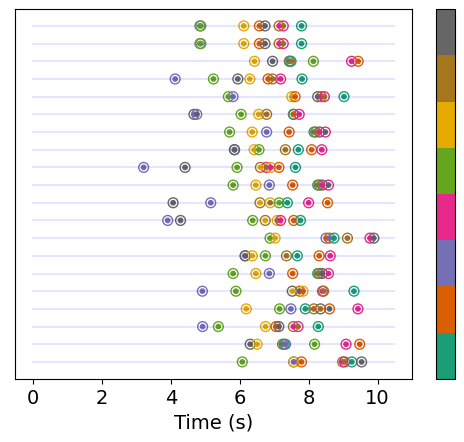

In [40]:
assignment_function=LAP
plt.rcParams.update({'font.size': 14})
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
plt.figure(figsize=(6.4, 4.8))
Crange=range(n_earthquake)
xaxis_max=lowest_loss_out.max()*1.1
cmap = plt.cm.get_cmap('Dark2', n_earthquake)
correct_rate=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    plt.plot([0,xaxis_max*9.5],[i,i],'-b',alpha=0.1)
    plt.scatter(tx*10,yaxis_i,marker='o', facecolors='none',s=50,alpha=1,edgecolors=cmap(ti[Crange]))
    plt.scatter(tx*10,yaxis_i,cmap=cmap,c=indexB[indexBi[Crange]],s=10,alpha=1)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
cbar=plt.colorbar()
plt.xlabel('Time (s)')
plt.yticks([])
cbar.ax.tick_params(length=0)
cbar.set_ticks([])
print('Accuracy:',correct_rate/n_station)

In [41]:
min_min_list=lowest_loss
assignment_function=LAP
indexB=assignment_function(loc_earthquake_coord,loc_earthquake_re)  #to get a order
Crange=range(n_earthquake)
correct_rate=0
dloss=0
for i in range(n_station):
    yaxis_i=np.ones(n_earthquake)*i
    tx=true_station_travelingtime[i,]
    ti=true_station_travelingtime_index[i,:]
    out=lowest_loss_out[i,:]
    indexBi=assignment_function(out.reshape(-1,1),tx.reshape(-1,1))
    dloss = dloss+np.sum((tx-out[indexBi])**2)
    correct_rate+=np.mean(ti[Crange]==indexB[indexBi[Crange]])
Accuracy=correct_rate/n_station
dloss=np.sqrt(dloss/n_station/n_earthquake)
print('Earthquake spatial locations:', np.sqrt(loc_error*3)*100,'km')
print('Accuracy:',Accuracy)

Earthquake spatial locations: 11.35074378143877 km
Accuracy: 0.75625
